# Merge Track Frame and Mission Plan for an Svalbard Cycle 19
---

This notebook will read all the data from a kmz for a cycle and save the results a gpkg.  It also take this plan an intersect it with the track frame data base so the frame show the actual extent of the data aquisition, including short frames and 80MHz half-width frames.

In [1]:
import geopandas as gpd
import pandas as pd
import fiona
from matplotlib import pyplot as plt
import shapely
from shapely.geometry import Polygon, MultiPolygon
import numpy as np
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
from datetime import datetime
import pytz
from subprocess import call
import os

## Support Functions

In [2]:
def computeTrack(myTime):
    '''
    Use time to compute track. Needs fine tuning near equator.
    '''
    secsCycle = 12. * 86400.
    track = ((myTime.timestamp() + 3100 + 25160 ) % secsCycle)/secsCycle * 173
    track = (track - 141) % 173
    frame = (track-int(track))*176
    #print(track, frame)
    return int(track)

def getMode(obsFile, layer, mode, direction, tMin=0, tMax=3600, bbox=(9, 75, 28,90)):
    '''
    Pull the rows for a layer (in kml file), mode (mode number), direction (ascending/descending).
    Optionally select only those data takes with a duration defined by tMin and tMax. 
    Filter geographically with bbox. 
    '''
    # Layer names contain direction
    if direction in layer and mode in layer:
        # read kml for specfied layer
        gdf = gpd.read_file(obsFile, bbox=bbox, drivers='LIBKML', layer=layer)
        # Only proceed if ther is data
        if gdf.shape[0] <= 0:
            return None
        # Compute data take duration and filter by duration
        gdf['deltaT'] = (gdf['end'] - gdf['begin']).apply(pd.Timedelta.total_seconds)
        tkeep = (gdf['deltaT'] > tMin) & (gdf['deltaT'] <= tMax)
        gdf = gdf[tkeep]
        # Compute the track number
        gdf['track'] = gdf['begin'].apply(computeTrack)
        gdf['mode'] = mode
        # reset indices to reflect order in frame
        gdf.reset_index(drop=True, inplace=True)
        print(f'M{mode} {gdf.shape[0]}', end=' ')
        if gdf.shape[0] > 0: 
            return gdf 
    return None

In [8]:
def getDataTakes(cycle, direction, bw, bbox=(-180, 58, 180, 90), saveToFile=True, tMin=0, tMax=3600, fileNameBase='Svalbard'): 
    '''
    Get all the data takes for a cycle (cycle number) with a given direction (ascending/descending).
    if saveToFile, then save to file with fileNameBase_bwMHz.Direction.cycleN.tMin.tMax.gpkg.
    '''
    obsFile = f'../observations/MPREFOBS349_qvis_cycle{cycle:03d}_230509.kml'
    # All L-band data modes for given BWs
    bwModes = {'80': ['150', '220', '246'],
               '40': ['151', '156', '223', '237', '238', '242', '247'],
               '20': ['148', '152', '215', '239', '241', '242'],
               '5': ['153', '232', '219', '218', '214' ]}
    modes = bwModes[str(bw)]
    print(obsFile)
    gdfs = []
    with open(obsFile, 'rb') as fp:
        for layer in fiona.listlayers(fp):
            for mode in modes:
                gdf = getMode(obsFile, layer, mode, direction, tMin=tMin, tMax=tMax)
                if gdf is not None:
                    gdf['bandwidth'] = bw
                    gdfs.append(gdf)
    if len(gdfs) == 0:
        return None
    allData = gpd.GeoDataFrame(pd.concat(gdfs))
    # Get rid of invalid timestamps so the results can be saved
    allData.drop('timestamp', inplace=True, axis=1)
    # Reset index to reflect current row order
    allData.reset_index(drop=True, inplace=True)
    # save if requested
    if saveToFile:
        shortDirection = {'ascending': 'Asc', 'descending': 'Desc'}[direction]
        allData.to_file(f'./{fileNameBase}_{bw}MHz.{shortDirection}.{cycle:03d}.{tMin}.{tMax}.gpkg')
    return allData

In [9]:
def mergePoly(myGeometry):
    ''' 
    Merge multipilygons. These appear to occur where a frame straddles the -180, 180 transition. 
    Update the <-180 values with +360, to produce continue > 180 values. Then merge the polygons.
    '''
    # Single polygon in the Multipolygon, the return it
    if len(myGeometry.geoms) == 1:
        return list(myGeometry.geoms)[0]
    # Loop through multipolygons and fix coordinates.
    polygons = []
    for poly in myGeometry.geoms:
        x, y = np.array(poly.exterior.xy)
        x[x < 0.] = x[x < 0.] + 360
        newPoly = Polygon(zip(x,y))
        polygons.append(newPoly)
    # merge the result
    merged = shapely.ops.unary_union(MultiPolygon(polygons))
    # If not merged discard
    if merged.geom_type == 'MultiPolygon':
        print(merged)
        return None
    return merged

In [10]:
def intersectFrameAndSwath(swath, frame):
    ''' 
    Take a swath row from the acquisition plan and a frame row from the track frame data base
    and find the intersection. Return an updated from with the geometry for just the area acquired
    '''
    oldGeometry = frame['geometry']
    newGeometry = swath['geometry'].intersection(oldGeometry)
    if newGeometry.geom_type == 'MultiPolygon':
        newGeometry = mergePoly(newGeometry)
        if newGeometry is None:
            return None
    frame['geometry'] = newGeometry
    areaCoverage = newGeometry.area/oldGeometry.area
    if swath['bandwidth'] == 80:
        areaCoverage /= 0.469
    frame['coverage'] = areaCoverage
    frame['mode'] = swath['mode']
    return frame


## Load KMLs

Convert kmz to kml.

In [11]:
cycle = 19
myKML = f'MPREFOBS349_qvis_cycle{cycle:03d}_230509.kml'
if not os.path.exists(f'observations/{myKML}'):
    call(f'cd ../observations; unzip {myKML.replace("kml", "kmz")}; mv solution_obs_best.kml {myKML}', shell=True)
    !ls -l ../observations/MPREFOBS349_qvis_cycle019_230509.kml

Archive:  MPREFOBS349_qvis_cycle019_230509.kmz
  inflating: solution_obs_best.kml   
-rw-rw-r-- 1 ian ian 10304276 May  9 11:56 ../observations/MPREFOBS349_qvis_cycle019_230509.kml


Read KMLs and convert to geopkgs. Seperate into short (<=8s) and long (>8s) data takes.

In [15]:
dfs =  {}
#
fileNameBase = 'Svalbard'
bbox = (-180,58, 180, 90)
for bw in [5, 20, 40, 80]:
    print(bw)
    dfs[f'Asc{bw}All'] = getDataTakes(cycle, 'ascending', bw, bbox=bbox, saveToFile=True, tMin=0, tMax=3600, fileNameBase=fileNameBase);
    dfs[f'Desc{bw}All']  = getDataTakes(cycle, 'descending', bw, bbox=bbox, saveToFile=True, tMin=0, tMax=3600, fileNameBase=fileNameBase);
    dfs[f'Asc{bw}Long'] = getDataTakes(cycle, 'ascending', bw, bbox=bbox, saveToFile=True, tMin=8, tMax=3600, fileNameBase=fileNameBase);
    dfs[f'Desc{bw}Long'] = getDataTakes(cycle, 'descending', bw, bbox=bbox, saveToFile=True, tMin=8, tMax=3600, fileNameBase=fileNameBase);
    dfs[f'Asc{bw}Short'] = getDataTakes(cycle, 'ascending', bw, bbox=bbox, saveToFile=True, tMin=0, tMax=8, fileNameBase=fileNameBase);
    dfs[f'Desc{bw}Short'] = getDataTakes(cycle, 'descending', bw, bbox=bbox, saveToFile=True, tMin=0, tMax=8, fileNameBase=fileNameBase);

5
../observations/MPREFOBS349_qvis_cycle019_230509.kml
M153 23 ../observations/MPREFOBS349_qvis_cycle019_230509.kml
M153 25 ../observations/MPREFOBS349_qvis_cycle019_230509.kml
M153 23 ../observations/MPREFOBS349_qvis_cycle019_230509.kml
M153 24 ../observations/MPREFOBS349_qvis_cycle019_230509.kml
M153 0 ../observations/MPREFOBS349_qvis_cycle019_230509.kml
M153 1 20
../observations/MPREFOBS349_qvis_cycle019_230509.kml
M148 1 ../observations/MPREFOBS349_qvis_cycle019_230509.kml
../observations/MPREFOBS349_qvis_cycle019_230509.kml
M148 1 ../observations/MPREFOBS349_qvis_cycle019_230509.kml
../observations/MPREFOBS349_qvis_cycle019_230509.kml
M148 0 ../observations/MPREFOBS349_qvis_cycle019_230509.kml
40
../observations/MPREFOBS349_qvis_cycle019_230509.kml
../observations/MPREFOBS349_qvis_cycle019_230509.kml
../observations/MPREFOBS349_qvis_cycle019_230509.kml
../observations/MPREFOBS349_qvis_cycle019_230509.kml
../observations/MPREFOBS349_qvis_cycle019_230509.kml
../observations/MPREFOBS

In [17]:
!ls ../observations/MPREFOBS349_qvis_cycle019_230509.kml

../observations/MPREFOBS349_qvis_cycle019_230509.kml


## Read Track-Frame

Read track frame data base and fix frames that straddle $\pm$180.

In [19]:
TF = gpd.read_file('../track-frame/MPREFOBS349_qvis_cycle019.gpkg', bbox=bbox)
TFall = gpd.read_file('../track-frame/MPREFOBS349_qvis_cycle019.gpkg')
TF['geometry'] = TF['geometry'].apply(mergePoly)

# Intersect Mission Plan with Track Frame

This step intersects the mission plan with the track frames and saves frame geometry that corresponds to the area actually acquired.
Note this step conversts data to 3413 to do the intersections and then back to 4326, which avoids problems with crossing the $\pm$180 boundary.

In [32]:
%%time
i=0
for mode in ['Asc5All', 'Desc5All', 'Asc20All', 'Desc20All']:
    swaths = dfs[mode]
    if swaths is None:
        continue
    correctedFrames = []
    for track in range(1, 174):
        TFTrack = TF[TF['track'] == track].to_crs(epsg=3413)
        swathsTrack = swaths[swaths['track'] == track].to_crs(epsg=3413)
        #
        for swath in swathsTrack.iterrows():
            # Get the frames that intersect the swath
            frames = TFTrack[TFTrack.intersects(swath[1]['geometry'])]
            # Intersect swath with frames
            for frame in frames.iterrows():
                #print(swath)
                correctedFrame = intersectFrameAndSwath(swath[1], frame[1])
                i +=1
                if correctedFrame is not None:
                    correctedFrames.append(correctedFrame)
    framedPlan = gpd.GeoDataFrame(pd.concat(correctedFrames, axis=1).transpose(), crs="EPSG:3413").to_crs(epsg=4236)
    framedPlan.reset_index(drop=True, inplace=True)
    framedPlan.to_file(f'./{mode}.{cycle:03d}.Framed.gpkg')
#X = framedPlan.to_crs(epsg=3413)



CPU times: user 7.47 s, sys: 104 ms, total: 7.57 s
Wall time: 7.74 s


geopandas.geodataframe.GeoDataFrame

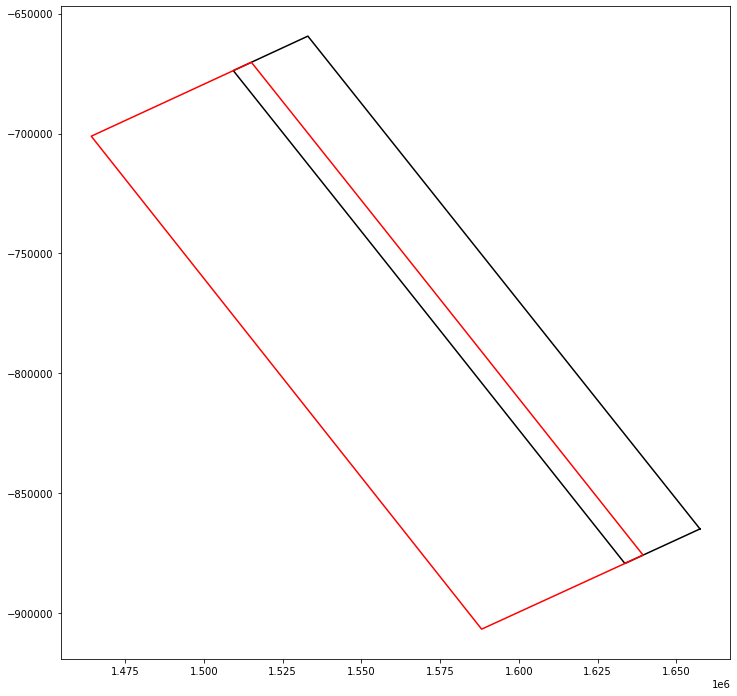

In [33]:
fig, ax = plt.subplots(figsize=(12,12))
for row in framedPlan.to_crs(epsg=3413).iterrows():
    #print(row)
    if row[1]['coverage'] < 0.15:
        ax.plot(*row[1]['geometry'].exterior.xy, color='k')
    else:
        ax.plot(*row[1]['geometry'].exterior.xy, color='r')
type(framedPlan)